# Detroit Land Bank Authority (DLBA) Occupancy Model

Geoff Perrin - 11.29.17

- This notebook is an update to the occupancy model I built for the DLBA last summer that predicts the occupancy of every single-family residential home in the city of Detroit. This model has many uses, but the initial use case was for the DLBA to better manage their housing inventory, and do a quicker and more accurate job sorting the DLBA housing stock into the oppropriate pipeline (i.e. demolition, buy-back, public auction, etc.)

In [3]:
#import data libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(222)
%matplotlib inline

In [181]:
#import machine learning / classification libraries
from sklearn.cross_validation import train_test_split
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier as RFC
import graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [5]:
import tensorflow as tf
from keras import models
from keras import layers
from keras import losses,optimizers,metrics,activations
from keras.optimizers import SGD

Using TensorFlow backend.


In [6]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

In [7]:
pd.options.display.max_columns = 120
pd.options.display.max_rows = 120

### Load Datasets

In [8]:
data = '../data/OccModel_TrainingInputData_20170117/'

#### DTE data

In [9]:
dte_df = pd.read_csv(data + 'DTE_ActiveAgreementsGasElectric_20160824.txt')

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (15,17,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
dte_df = dte_df[['Ref_ID', 'DS_SER_PRODUCT_TYPE']]

In [11]:
### Deduplicate data
dte_df = dte_df.drop_duplicates()

In [12]:
### long to wide reshape on DS_SER_PRODUCT_TYPE
dte_df['gas_dummy'] = [1 if x=='GAS' else 0 for x in dte_df['DS_SER_PRODUCT_TYPE']]
dte_df['electric_dummy'] = [1 if x=='ELC' else 0 for x in dte_df['DS_SER_PRODUCT_TYPE']]
dte_df = dte_df.groupby(['Ref_ID'], as_index=False)['gas_dummy', 'electric_dummy'].sum()

#### DWSD (Water Department) data

In [13]:
dwsd_df = pd.read_csv(data + 'DWSD_12MoUsage_20160815.csv')

In [14]:
dwsd_df = dwsd_df[['Ref_ID', 'Street_ID', 'Add_Geocode', 'ZIP', 
                   u'TOTALACCOUNTBALANCE', u'DECEMBER', u'NOVEMBER',
                   u'OCTOBER', u'SEPTEMBER', u'AUGUST', u'JULY', 
                   u'JUNE', u'MAY', u'APRIL',u'MARCH', u'FEBRUARY', 
                   u'JANUARY']]

In [15]:
dwsd_df['year_total'] = dwsd_df.DECEMBER + dwsd_df.NOVEMBER + dwsd_df.OCTOBER + dwsd_df.SEPTEMBER +\
                        dwsd_df.AUGUST + dwsd_df.JULY +dwsd_df.JUNE + dwsd_df.MAY + dwsd_df.APRIL +\
                        dwsd_df.MARCH + dwsd_df.FEBRUARY + dwsd_df.JANUARY

In [16]:
### sum water amounts of duplicate properties 
dwsd_df = dwsd_df.groupby(['Ref_ID'], as_index=False)[ u'TOTALACCOUNTBALANCE',
       u'DECEMBER', u'NOVEMBER', u'OCTOBER', u'SEPTEMBER', u'AUGUST', u'JULY',
       u'JUNE', u'MAY', u'APRIL', u'MARCH', u'FEBRUARY', u'JANUARY',
       u'year_total'].sum()

#### USPS / DFD (Fire Department) data

In [17]:
usps_df = pd.read_csv(data + 'Fire_USPS_Data_8_18_16.csv')

In [18]:
usps_df.columns = [u'Account Name', u'Ref_ID', u'Property Class', u'USPS: Last Update',
       u'USPS: Vacancy Indicated', u'DFD Fire: Occurrence Date',
       u'DFD Fire: Structure Status']

In [19]:
### subset to residential data
usps_df = usps_df[usps_df['Property Class'] == 'Residential-Structure']

In [20]:
### create DFD fire dummy
usps_df['fire_occured_dummy'] = [0 if pd.isnull(x) else 1 for x in usps_df['DFD Fire: Occurrence Date']]

In [21]:
### create USPS occupied dummy
usps_df['usps_occupied_dummy'] = [1 if x == "No" else 0 for x in usps_df['USPS: Vacancy Indicated']]

In [22]:
### Just keep variables we need
usps_df = usps_df[[u'Ref_ID', u'fire_occured_dummy',
                   u'usps_occupied_dummy']]

#### QVF (voter registration) data

In [23]:
vote_df = pd.read_csv(data + 'QVF_Detroit20160816.csv')

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,2,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [24]:
vote_df = vote_df[['Ref_ID']]
vote_df['vote_dummy'] = 1

In [25]:
vote_df = vote_df.drop_duplicates()

#### Blext data (Motor City Mapping data)
- https://motorcitymapping.org/#t=overview&s=detroit&f=all

In [26]:
mcm_df = pd.read_csv(data + 'Recent_Blexts_8_18_16_v2.csv')

In [27]:
mcm_df = mcm_df[[u'Account Name', u'Parcel ID', u'MCM Structure',
       u'Property Class', u'MCM Occupancy', u'MCM Blext Created At']]

In [28]:
mcm_df.columns = [u'Account Name', u'Ref_ID', u'MCM Structure',
       u'Property Class', u'MCM Occupancy', u'MCM Blext Created At']

In [29]:
### subset to residential data
mcm_df = mcm_df[mcm_df['Property Class'] == 'Residential-Structure']

In [30]:
### subset to non-lot properties
mcm_df = mcm_df[mcm_df['MCM Structure'] == 'Yes']

In [31]:
len(mcm_df)

64783

#### Note from Alice Hargreaves:

NOTE: code "maybe" or "partial" occupied houses as occupied... Ive googled a lot of the "maybes" and theyre nearly all structually sound --- i.e., someone could occupy it, but someone might not be sleeping there every night - GP line of thinking about 3k rows are "maybe" or "partial" 

(R-code below):

In [32]:
def occupancy_binary(x):
    if (x == "Occupied") | (x == "Unoccupied"):
        return x
    else:
        return "Occupied"

In [33]:
mcm_df['MCM Occupancy'] = mcm_df['MCM Occupancy'].apply(occupancy_binary)

In [34]:
### create DFD fire dummy
mcm_df['mcm_occupancy_dummy'] = [1 if x == 'Occupied' else 0 for x in mcm_df['MCM Occupancy']]

### Merge Datasets together

In [35]:
# merge mcm data with usps / dfd data
merged_train = mcm_df.merge(usps_df, how='left', on='Ref_ID')

In [36]:
#merge on voter (qvf) data
merged_train2 = merged_train.merge(vote_df, how='left', on='Ref_ID')

In [37]:
#fill in NaNs for vote_dummy
merged_train2['vote_dummy'] = [0 if pd.isnull(x) else 1 for x in merged_train2['vote_dummy']]

In [38]:
#merge on dwsd data
merged_train3 = merged_train2.merge(dwsd_df, how='left', on='Ref_ID')
#fill in 0s for properties w/ no water
merged_train3.fillna(value=0,inplace=True)

In [39]:
#merge on dte data
merged_train_final = merged_train3.merge(dte_df, how='left', on='Ref_ID')
merged_train_final.fillna(value=0,inplace=True)

In [40]:
merged_train_final.head()

,Account Name,Ref_ID,MCM Structure,Property Class,MCM Occupancy,MCM Blext Created At,mcm_occupancy_dummy,fire_occured_dummy,usps_occupied_dummy,vote_dummy,TOTALACCOUNTBALANCE,DECEMBER,NOVEMBER,OCTOBER,SEPTEMBER,AUGUST,JULY,JUNE,MAY,APRIL,MARCH,FEBRUARY,JANUARY,year_total,gas_dummy,electric_dummy
0,13776 St Louis,13011231.,Yes,Residential-Structure,Occupied,8/16/2016 14:52,1,0,1,0,129.35,200.0,8000.0,8100.0,200.0,200.0,200.0,200.0,100.0,200.0,100.0,200.0,100.0,17800.0,1.0,1.0
1,13782 St Louis,13011232.,Yes,Residential-Structure,Occupied,8/16/2016 14:52,1,0,1,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13790 St Louis,13011233.,Yes,Residential-Structure,Occupied,8/16/2016 14:51,1,0,1,0,27.97,900.0,900.0,800.0,800.0,1100.0,900.0,900.0,800.0,800.0,800.0,800.0,1100.0,10600.0,1.0,1.0
3,13777 St Louis,13011536.,Yes,Residential-Structure,Unoccupied,8/16/2016 14:50,0,0,0,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,13761 St Louis,13011538.,Yes,Residential-Structure,Occupied,8/16/2016 14:49,1,0,1,0,13.87,400.0,300.0,300.0,300.0,300.0,300.0,300.0,200.0,300.0,200.0,300.0,300.0,3500.0,1.0,1.0


In [41]:
merged_train_final.columns

Index([        u'Account Name',               u'Ref_ID',
              u'MCM Structure',       u'Property Class',
              u'MCM Occupancy', u'MCM Blext Created At',
        u'mcm_occupancy_dummy',   u'fire_occured_dummy',
        u'usps_occupied_dummy',           u'vote_dummy',
        u'TOTALACCOUNTBALANCE',             u'DECEMBER',
                   u'NOVEMBER',              u'OCTOBER',
                  u'SEPTEMBER',               u'AUGUST',
                       u'JULY',                 u'JUNE',
                        u'MAY',                u'APRIL',
                      u'MARCH',             u'FEBRUARY',
                    u'JANUARY',           u'year_total',
                  u'gas_dummy',       u'electric_dummy'],
      dtype='object')

In [42]:
len(merged_train_final)

64783

### Visualize Data

In [43]:
data_corr = merged_train_final[['mcm_occupancy_dummy', u'fire_occured_dummy', 
                                u'usps_occupied_dummy',
                                u'vote_dummy', u'TOTALACCOUNTBALANCE', u'DECEMBER',
                                u'NOVEMBER', u'OCTOBER', u'SEPTEMBER', u'AUGUST',
                                u'JULY', u'JUNE', u'MAY', u'APRIL', u'MARCH', u'FEBRUARY',
                                u'JANUARY', u'year_total', u'gas_dummy', u'electric_dummy']]

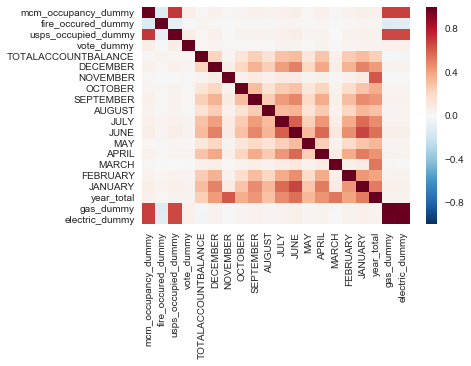

In [44]:
sns.heatmap(data_corr.corr(), annot=False)

In [45]:
data_corr2 = merged_train_final[['mcm_occupancy_dummy', 
                                 u'fire_occured_dummy', u'usps_occupied_dummy',
                                u'vote_dummy', u'year_total', u'electric_dummy']]

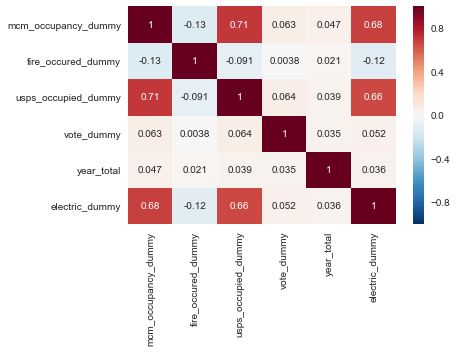

In [46]:
sns.heatmap(data_corr2.corr(), annot=True)

## Classification

In [47]:
merged_train_final.columns

Index([        u'Account Name',               u'Ref_ID',
              u'MCM Structure',       u'Property Class',
              u'MCM Occupancy', u'MCM Blext Created At',
        u'mcm_occupancy_dummy',   u'fire_occured_dummy',
        u'usps_occupied_dummy',           u'vote_dummy',
        u'TOTALACCOUNTBALANCE',             u'DECEMBER',
                   u'NOVEMBER',              u'OCTOBER',
                  u'SEPTEMBER',               u'AUGUST',
                       u'JULY',                 u'JUNE',
                        u'MAY',                u'APRIL',
                      u'MARCH',             u'FEBRUARY',
                    u'JANUARY',           u'year_total',
                  u'gas_dummy',       u'electric_dummy'],
      dtype='object')

In [48]:
X = merged_train_final[[u'fire_occured_dummy', u'usps_occupied_dummy',
                                u'vote_dummy', u'year_total', u'electric_dummy']]
y = merged_train_final.mcm_occupancy_dummy

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [208]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=123)

In [209]:
len(X_train)

31743

### Class imbalance correction

In [210]:
merged_train_final.groupby(['mcm_occupancy_dummy'], as_index=False)['fire_occured_dummy'].count()

,mcm_occupancy_dummy,fire_occured_dummy
0,0,12798
1,1,51985


### Logistic Classification

In [211]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [212]:
predictions = logmodel.predict(X_test)

In [213]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.85      0.71      0.77      3882
          1       0.93      0.97      0.95     15553

avg / total       0.91      0.92      0.91     19435



In [214]:
print(roc_auc_score(y_test, predictions))

0.83973448155


### use Over Sampling to correct class imbalance
- code taken from http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html

In [215]:
ros = RandomOverSampler(random_state=0, ratio='minority')
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

In [216]:
sum(y_train)*1.0 / len(y_train)

0.80370475380398831

In [217]:
sum(y_resampled)*1.0 / len(y_resampled)

0.5

In [218]:
logmodel = LogisticRegression()
logmodel.fit(X_resampled,y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [219]:
predictions = logmodel.predict(X_test)

In [220]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.70      0.89      0.78      3882
          1       0.97      0.90      0.94     15553

avg / total       0.92      0.90      0.91     19435



In [221]:
print(roc_auc_score(y_test, predictions))

0.896360993022


### Use SMOTE to correct class imbalance
- code taken from http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html

In [222]:
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)

In [223]:
logmodel = LogisticRegression()
logmodel.fit(X_resampled,y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [224]:
predictions = logmodel.predict(X_test)

In [225]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.69      0.89      0.78      3882
          1       0.97      0.90      0.93     15553

avg / total       0.92      0.90      0.90     19435



In [226]:
print(roc_auc_score(y_test, predictions))

0.896331950384


### Decision Trees

In [227]:
clf = tree.DecisionTreeClassifier()

In [228]:
feature_importance = clf.fit(X_resampled, y_resampled).feature_importances_
Feature_importance_df = pd.DataFrame([list(X_train.columns), list(feature_importance)]).T
Feature_importance_df.columns = ["variables", "importance"]
Feature_importance_df.sort_values(by="importance", ascending=False)

,variables,importance
4,electric_dummy,0.782534
1,usps_occupied_dummy,0.133766
3,year_total,0.0714256
0,fire_occured_dummy,0.00684491
2,vote_dummy,0.00542964


In [229]:
#### Can also use built in sci-kit learn feature selection (Recursive Feature Elimination)

In [230]:
rfe = RFE(clf, n_features_to_select=5)

In [231]:
rfe.fit(X_resampled, y_resampled)

RFE(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
  n_features_to_select=5, step=1, verbose=0)

In [232]:
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True]
[1 1 1 1 1]


In [233]:
featured_columns = (np.array(X.columns) * rfe.support_)
featured_columns = [var for var in featured_columns if var]

In [234]:
featured_columns

['fire_occured_dummy',
 'usps_occupied_dummy',
 'vote_dummy',
 u'year_total',
 'electric_dummy']

In [235]:
X_top_features = X[featured_columns]

### Predictions

In [236]:
predictions = rfe.predict(X_test)

In [237]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.70      0.88      0.78      3882
          1       0.97      0.91      0.94     15553

avg / total       0.92      0.90      0.91     19435



In [238]:
def accuracy(true, predictions):
    tot_true = (true == predictions)
    return 1.0 * sum(tot_true) / len(true)

In [239]:
#precision of unoccupied homes
def pct_class_unocc_homes_accually_occ(true, predictions):
    #number of true positives of unoccupied homes
    TP = ((true == 0) & (true == predictions))
    #number of predicted unoccupied homes
    PP = (predictions == 0)
    return 1-(sum(TP)*1.0 / sum(PP))
    

In [240]:
accuracy(y_test, predictions)

0.9015178801131979

In [241]:
pct_class_unocc_homes_accually_occ(y_test, predictions)

0.29918367346938779

In [242]:
feature_names = [u'fire_occured_dummy', u'usps_occupied_dummy',\
                 u'vote_dummy', u'year_total', u'electric_dummy']

In [243]:
### Export decision tree graph
DC_graph = tree.export_graphviz(clf, out_file=None, 
                         feature_names=feature_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(DC_graph) 
graph.render("decision_tree_graph") 

'decision_tree_graph.pdf'

## Random Forest

In [244]:
r_tree = RFC()

In [245]:
param_grid = {'max_depth': [9, 11, 13, 15, 17], 'n_estimators': np.arange(1,602,100)}
r_tree_tuned = GridSearchCV(r_tree, param_grid)
r_tree_tuned.fit(X_resampled, y_resampled)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([  1, 101, 201, 301, 401, 501, 601]), 'max_depth': [9, 11, 13, 15, 17]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [246]:
feature_importance = r_tree_tuned.best_estimator_.fit(X_resampled, y_resampled).feature_importances_

In [247]:
Feature_importance_df = pd.DataFrame([list(X_train.columns), list(feature_importance)]).T
Feature_importance_df.columns = ["variables", "importance"]
Feature_importance_df.sort_values(by="importance", ascending=False, inplace=True)
Feature_importance_df.reset_index(inplace=True)
Feature_importance_df.drop(u'index', axis=1, inplace=True)

In [248]:
Feature_importance_df

,variables,importance
0,electric_dummy,0.441685
1,usps_occupied_dummy,0.34008
2,year_total,0.200536
3,fire_occured_dummy,0.011473
4,vote_dummy,0.00622567


In [249]:
r_tree_tuned.best_params_

{'max_depth': 17, 'n_estimators': 201}

### Threshold tuning - need to do this on the training set NOT THE TEST SET 
if you tune the threshold to the test set, then you're just going to overfit the data

In [254]:
predictions = r_tree_tuned.predict(X_valid)
predict_probability = r_tree_tuned.predict_proba(X_valid)[:,1]

In [255]:
# compute fpr, tpr, thresholds and roc_auc

In [259]:
fpr, tpr, thresholds = roc_curve(y_valid, predict_probability)

In [260]:
roc_auc = auc(fpr, tpr) # compute area under the curve
print(roc_auc)

0.928607103635


In [277]:
### find the threshold where ((1-fpr) + tpr) are max
optimal_threshold = thresholds[((1-fpr)+tpr).argmax()]
optimal_threshold

0.67247165519144381

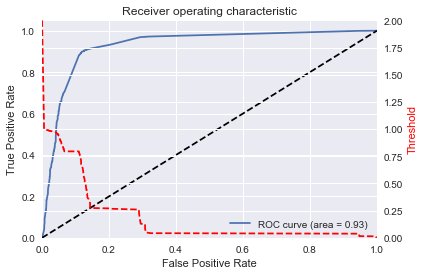

In [270]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
 
# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])
 
plt.show()

### Final Model Evaluation

### Model Evaluation:

- we want to minimize homes being misclassified as unoccupied when they are really occupied
- this means we want to maximize the precision of 0 (unoccupied) as that minimizes the statement above
- False Negative of 0 means a home is classified as being occupied but is really unoccupied

<img src="Precisionrecall.png",width=300,height=300>

In [273]:
predictions = r_tree_tuned.predict(X_test)
predict_probability = r_tree_tuned.predict_proba(X_test)[:,1]

In [274]:
accuracy(y_test, predictions)

0.9027527656290198

In [295]:
def bool_to_num(v):
    if v == 'True':
        return '1'
    elif v == 'False':
        return '0'
    else:
        return v

In [299]:
predictions_w_threshold = np.vectorize(bool_to_num)(predict_probability>optimal_threshold).astype(int)

In [300]:
accuracy(y_test, predictions_w_threshold)

0.8944687419603807

In [301]:
pct_class_unocc_homes_accually_occ(y_test, predictions)

0.29548254620123204

In [302]:
print(roc_auc_score(y_test, predictions))

0.895650214405


In [303]:
print(roc_auc_score(y_test, predictions_w_threshold))

0.894727027853


## Dense Neural Network

In [95]:
dnn_keras_model = models.Sequential()
dnn_keras_model.add(layers.Dense(units=10, input_dim=5, activation='relu'))
dnn_keras_model.add(layers.Dense(units=10, input_dim=10, activation='relu'))
dnn_keras_model.add(layers.Dense(units=2, activation='softmax'))

In [96]:
opt = SGD(lr=0.01)
dnn_keras_model.compile(optimizer= opt,
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [97]:
scaler = MinMaxScaler()

In [98]:
scaled_x_train = scaler.fit_transform(X_resampled)

In [99]:
scaled_x_test = scaler.fit_transform(X_test)

In [100]:
dnn_keras_model.fit(scaled_x_train,y_resampled,epochs=10)

Epoch 1/10
72864/72864 [==============================] - 5s - loss: 0.3615 - acc: 0.8688     
Epoch 2/10
72864/72864 [==============================] - 4s - loss: 0.3064 - acc: 0.8867     
Epoch 3/10
72864/72864 [==============================] - 5s - loss: 0.3057 - acc: 0.8865     
Epoch 4/10
72864/72864 [==============================] - 5s - loss: 0.3054 - acc: 0.8867     
Epoch 5/10
72864/72864 [==============================] - 4s - loss: 0.3050 - acc: 0.8870     
Epoch 6/10
72864/72864 [==============================] - 4s - loss: 0.3050 - acc: 0.8870     
Epoch 7/10
72864/72864 [==============================] - 4s - loss: 0.3048 - acc: 0.8871     
Epoch 8/10
72864/72864 [==============================] - 5s - loss: 0.3048 - acc: 0.8870     
Epoch 9/10
72864/72864 [==============================] - 4s - loss: 0.3048 - acc: 0.8871     
Epoch 10/10
72864/72864 [==============================] - 4s - loss: 0.3049 - acc: 0.8871     


In [101]:
predictions = dnn_keras_model.predict_classes(scaled_x_test)

18560/19435 [===========================>..] - ETA: 0s

In [102]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.64      0.91      0.75      3882
          1       0.97      0.87      0.92     15553

avg / total       0.91      0.88      0.89     19435



In [103]:
print(roc_auc_score(y_test, predictions))

0.889174095272


## Read in full data

In [104]:
data_full = '../data/OccModel_FittingFullData_20170922/'

#### DTE data

In [105]:
dte_full_df = pd.read_csv(data_full + 'DTE_ActiveGasElectric_GeocoderMatches_20170920.txt')

In [106]:
dte_full_df = dte_full_df[['Ref_ID', 'DS_SER_PRODUCT_TYPE']]

In [107]:
### Deduplicate data
dte_full_df = dte_full_df.drop_duplicates()

In [108]:
### long to wide reshape on DS_SER_PRODUCT_TYPE
dte_full_df['gas_dummy'] = [1 if x=='GAS' else 0 for x in dte_full_df['DS_SER_PRODUCT_TYPE']]
dte_full_df['electric_dummy'] = [1 if x=='ELC' else 0 for x in dte_full_df['DS_SER_PRODUCT_TYPE']]
dte_full_df = dte_full_df.groupby(['Ref_ID'], as_index=False)['gas_dummy', 'electric_dummy'].sum()

In [109]:
len(dte_full_df)

186539

#### DWSD (Water Department) data

In [110]:
dwsd_full_df = pd.read_csv(data_full + 'DWSD_12Mo_20170825.csv')

In [111]:
def pandas_to_numeric(s):
    s = s.str.replace(',', '')
    return pd.to_numeric(s, errors='coerce')

In [112]:
dwsd_full_df[[u'NINE', u'TEN', u'ELEVEN', u'TWELVE', u'ONE', u'TWO', u'THREE', \
              u'FOUR', u'FIVE', u'SIX', u'SEVEN',u'EIGHT']] \
            = dwsd_full_df[[u'NINE', u'TEN', u'ELEVEN', u'TWELVE', u'ONE', \
                            u'TWO', u'THREE', u'FOUR', u'FIVE', u'SIX', u'SEVEN',\
                            u'EIGHT']].apply(pandas_to_numeric)

In [113]:
dwsd_full_df['year_total'] = dwsd_full_df.NINE + dwsd_full_df.TEN + dwsd_full_df.ELEVEN + \
                             dwsd_full_df.TWELVE + dwsd_full_df.ONE + dwsd_full_df.TWO + \
                             dwsd_full_df.THREE + dwsd_full_df.FOUR + dwsd_full_df.FIVE + \
                             dwsd_full_df.SIX + dwsd_full_df.SEVEN + dwsd_full_df.EIGHT

In [114]:
dwsd_full_df = dwsd_full_df[['REPAIREDPARCELID', u'year_total']]

In [115]:
dwsd_full_df.columns = ['Ref_ID', 'year_total']

In [116]:
### sum water amounts of duplicate properties 
dwsd_full_df = dwsd_full_df.groupby(['Ref_ID'], as_index=False)[ u'year_total'].sum()

#### USPS / DFD (Fire Department) data

In [117]:
usps_full_df = pd.read_csv(data_full + 'DFD_USPS_20170829.csv')

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [118]:
usps_full_df.head()

,Account Name,Parcel ID,Property Class,USPS: Last Update,USPS: Vacancy Indicated,DFD Fire: Occurrence Date
0,2411 Wendell,20007595.,Residential-Structure,8/1/2017,No,8/19/2017
1,17208 Ohio,16033858.,Residential-Structure,8/1/2017,No,8/19/2017
2,60 E Euclid,01002534.,Residential-Structure,8/1/2017,No,8/19/2017
3,8154 W Lafayette,20002305.,Residential-Structure,8/1/2017,Yes,8/19/2017
4,16691 Fairmount Dr,21025509.001,Residential-Structure,8/1/2017,No,8/18/2017


In [119]:
usps_full_df.columns = [u'Account Name', u'Ref_ID', u'Property Class', u'USPS: Last Update',
       u'USPS: Vacancy Indicated', u'DFD Fire: Occurrence Date',]

In [120]:
### subset to residential data
usps_full_df = usps_full_df[usps_full_df['Property Class'] == 'Residential-Structure']

In [121]:
### create DFD fire dummy
usps_full_df['fire_occured_dummy'] = [0 if pd.isnull(x) else 1 for x in usps_full_df['DFD Fire: Occurrence Date']]

In [122]:
### create USPS occupied dummy
usps_full_df['usps_occupied_dummy'] = [1 if x == "No" else 0 for x in usps_full_df['USPS: Vacancy Indicated']]

In [123]:
### Just keep variables we need
usps_full_df = usps_full_df[[u'Ref_ID', u'fire_occured_dummy',
                   u'usps_occupied_dummy']]

#### QVF (voter registration) data

In [124]:
vote_full_df = pd.read_csv(data_full + 'QVF_Detroit_Geo_20170717.txt')

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [125]:
vote_full_df = vote_full_df[['Ref_ID']]
vote_full_df['vote_dummy'] = 1

In [126]:
vote_full_df = vote_full_df.drop_duplicates()

#### Address Data

In [127]:
addy_full_df = pd.read_csv(data_full + 'ResStructureParcelsAccountIDs_20170920.csv')

In [128]:
addy_full_df.head()

,Account ID,Parcel ID,Account Name,Property Ownership,Property Class
0,001j000000IeFOx,22126050-1,14200 W Outer Drive,Non-DLBA Owned,Residential-Structure
1,001j000000IeFOp,22126047-9,14180 W Outer Drive,Non-DLBA Owned,Residential-Structure
2,001j000000IeFOZ,22126046.,14164 W Outer Drive,Non-DLBA Owned,Residential-Structure
3,001j000000IeFOM,22126045.,14158 W Outer Drive,Non-DLBA Owned,Residential-Structure
4,001j000000IeFO9,22126044.,14150 W Outer Drive,Non-DLBA Owned,Residential-Structure


In [129]:
### subset to residential data
addy_full_df = addy_full_df[addy_full_df['Property Class'] == 'Residential-Structure']

In [130]:
addy_full_df.columns = ['Account_ID', 'Ref_ID', 'Account_Name', 'Property_Ownership', 'Property_Class']

In [131]:
len(addy_full_df)

234869

### Merge Datasets together

In [132]:
# merge mcm data with usps / dfd data
merged_full = addy_full_df.merge(usps_full_df, how='left', on='Ref_ID')

In [133]:
#merge on voter (qvf) data
merged_full2 = merged_full.merge(vote_full_df, how='left', on='Ref_ID')

In [134]:
#fill in NaNs for vote_dummy
merged_full2['vote_dummy'] = [0 if pd.isnull(x) else 1 for x in merged_full2['vote_dummy']]

In [135]:
#merge on dwsd data
merged_full3 = merged_full2.merge(dwsd_full_df, how='left', on='Ref_ID')
#fill in 0s for properties w/ no water
merged_full3.fillna(value=0,inplace=True)

In [136]:
#merge on dte data
merged_full_final = merged_full3.merge(dte_full_df, how='left', on='Ref_ID')
merged_full_final.fillna(value=0,inplace=True)

In [137]:
merged_full_final.head()

,Account_ID,Ref_ID,Account_Name,Property_Ownership,Property_Class,fire_occured_dummy,usps_occupied_dummy,vote_dummy,year_total,gas_dummy,electric_dummy
0,001j000000IeFOx,22126050-1,14200 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,0.0,1.0,1.0
1,001j000000IeFOp,22126047-9,14180 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,9400.0,0.0,0.0
2,001j000000IeFOZ,22126046.,14164 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,2100.0,0.0,0.0
3,001j000000IeFOM,22126045.,14158 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,14700.0,0.0,0.0
4,001j000000IeFO9,22126044.,14150 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,3100.0,1.0,1.0


In [138]:
merged_full_final.columns

Index([         u'Account_ID',              u'Ref_ID',        u'Account_Name',
        u'Property_Ownership',      u'Property_Class',  u'fire_occured_dummy',
       u'usps_occupied_dummy',          u'vote_dummy',          u'year_total',
                 u'gas_dummy',      u'electric_dummy'],
      dtype='object')

## Applying Predictions to full dataset

In [139]:
X.columns

Index([ u'fire_occured_dummy', u'usps_occupied_dummy',          u'vote_dummy',
                u'year_total',      u'electric_dummy'],
      dtype='object')

In [142]:
merged_full_final.copy()[['fire_occured_dummy', u'usps_occupied_dummy', u'vote_dummy',
                u'year_total', u'electric_dummy']].head()

,fire_occured_dummy,usps_occupied_dummy,vote_dummy,year_total,electric_dummy
0,0.0,1.0,1,0.0,1.0
1,0.0,1.0,1,9400.0,0.0
2,0.0,1.0,1,2100.0,0.0
3,0.0,1.0,1,14700.0,0.0
4,0.0,1.0,1,3100.0,1.0


In [143]:
predictions_df = merged_full_final.copy()[['fire_occured_dummy', u'usps_occupied_dummy', u'vote_dummy',
                u'year_total', u'electric_dummy']]

In [145]:
merged_full_final['prediction_occupancy'] = r_tree_tuned.predict(predictions_df)
merged_full_final['prediction_occupancy_proba'] = r_tree_tuned.predict_proba(predictions_df)[:,1]

In [146]:
merged_full_final.head()

,Account_ID,Ref_ID,Account_Name,Property_Ownership,Property_Class,fire_occured_dummy,usps_occupied_dummy,vote_dummy,year_total,gas_dummy,electric_dummy,prediction_occupancy,prediction_occupancy_proba
0,001j000000IeFOx,22126050-1,14200 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,0.0,1.0,1.0,1,0.911535
1,001j000000IeFOp,22126047-9,14180 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,9400.0,0.0,0.0,1,0.989092
2,001j000000IeFOZ,22126046.,14164 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,2100.0,0.0,0.0,1,0.987325
3,001j000000IeFOM,22126045.,14158 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,14700.0,0.0,0.0,1,0.986711
4,001j000000IeFO9,22126044.,14150 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,3100.0,1.0,1.0,1,0.745649


### Investigating Final Housing Statistics

#### Number of occupied homes in Detroit

In [147]:
len(merged_full_final)

234869

In [148]:
sum(merged_full_final.prediction_occupancy)

172056

In [149]:
sum(merged_full_final.prediction_occupancy) * 1.0 / len(merged_full_final)

0.73256155559056324

#### Number of occupied homes owned by DLBA

In [169]:
merged_full_final.groupby(['Property_Ownership'])['prediction_occupancy'].sum()

Property_Ownership
DLBA Owned                       1683
Former Property of Interest      3066
Formerly DLBA Owned               921
Non-DLBA Owned                 163915
Property of Interest             1299
Resolved via NAP                  684
Under Compliance                  488
Name: prediction_occupancy, dtype: int64

In [171]:
merged_full_final.groupby(['Property_Ownership'])['prediction_occupancy'].count()

Property_Ownership
DLBA Owned                      31146
Former Property of Interest      5311
Formerly DLBA Owned              1172
Non-DLBA Owned                 191132
Property of Interest             3159
Resolved via NAP                  938
Under Compliance                 2011
Name: prediction_occupancy, dtype: int64

In [172]:
1683*1.0 / 31146

0.05403583124638798

## Export Final Data

In [304]:
# to .csv
merged_full_final.to_csv('OPM_output_final.csv', sep='\t')

In [305]:
merged_full_final.head()

,Account_ID,Ref_ID,Account_Name,Property_Ownership,Property_Class,fire_occured_dummy,usps_occupied_dummy,vote_dummy,year_total,gas_dummy,electric_dummy,prediction_occupancy,prediction_occupancy_proba
0,001j000000IeFOx,22126050-1,14200 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,0.0,1.0,1.0,1,0.911535
1,001j000000IeFOp,22126047-9,14180 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,9400.0,0.0,0.0,1,0.989092
2,001j000000IeFOZ,22126046.,14164 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,2100.0,0.0,0.0,1,0.987325
3,001j000000IeFOM,22126045.,14158 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,14700.0,0.0,0.0,1,0.986711
4,001j000000IeFO9,22126044.,14150 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,3100.0,1.0,1.0,1,0.745649
